In [1]:
import torch
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# baixa o dataset
data_folder = '/working/kaggle'
CIFAR10(data_folder, download=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 61382500.61it/s]


Extracting /working/kaggle/cifar-10-python.tar.gz to /working/kaggle


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /working/kaggle
    Split: Train

In [4]:
class Colorize(CIFAR10): # herda da CIFAR10
    """
    Classe que constrói uma versão modificada do dataset CIFAR10 para posterior colorização
    A função __getitem__ é sobrescrita
    """
    def __init__(self, root, train):
        super().__init__(root, train) # diretório onde está o DS e se é de treino ou não
    
    def __getitem__(self, ix):
        im, _ = super().__getitem__(ix) # retorna a imagem e a classe, que não interessa
        bw = im.convert('L').convert('RGB') # cria uma versão graysclae da imagem, mas em formato RGB
        bw, im = np.array(bw)/255., np.array(im)/255. # normaliza ambas as imagens
        bw, im = [torch.tensor(i).permute(2, 0, 1).to(device).float() for i in [bw, im]] # converte ambas as imagens para tensor, redimensiona para o pytorch, coloca em device e converte para float
        return bw, im

trn_ds = Colorize(data_folder, train=True) # cria o conjunto de treino para colorização
val_ds = Colorize(data_folder, train=False) # cria o conjunto de validação

batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True) # cria o dataloader para batches de treino
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False) # cria o dataloader para batcher de validação

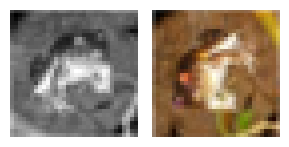

In [5]:
# visualizando um exemplo
a, b = trn_ds[0]
fig, ax = plt.subplots(1, 2, figsize=(3,3))
ax[0].imshow(a[0].cpu().numpy(), cmap='gray')
ax[0].axis('off')
ax[1].imshow(b.permute(2, 1, 0).cpu().numpy(), cmap='gray')
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [6]:
class Identity(nn.Module):
    """
    Retorna o input sem mudanças
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x
    
class DownConv(nn.Module):
    """
    Faz o downsample da imagem, extraindo as features
    """
    def __init__(self, ni, no, maxpool=True):
        super().__init__()
        self.model = nn.Sequential(
            nn.MaxPool2d(2) if maxpool else Identity(),
            nn.Conv2d(ni, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x):
        return self.model(x)
    
class UpConv(nn.Module):
    """
    Faz o upsample da imagem
    """
    def __init__(self, ni, no, maxpool=True):
        super().__init__()
        self.convtranspose = nn.ConvTranspose2d(ni, no, 2, stride=2)
        self.convlayers = nn.Sequential(
            nn.Conv2d(no+no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
    def forward(self, x, y):
        x = self.convtranspose(x)
        x = torch.cat([x,y], axis=1)
        x = self.convlayers(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DownConv( 3, 64, maxpool=False)
        self.d2 = DownConv( 64, 128)
        self.d3 = DownConv( 128, 256)
        self.d4 = DownConv( 256, 512)
        self.d5 = DownConv( 512, 1024)
        self.u5 = UpConv (1024, 512)
        self.u4 = UpConv ( 512, 256)
        self.u3 = UpConv ( 256, 128)
        self.u2 = UpConv ( 128, 64)
        self.u1 = nn.Conv2d(64, 3, kernel_size=1, stride=1)

    def forward(self, x):
        x0 = self.d1( x) 
        x1 = self.d2(x0) 
        x2 = self.d3(x1) 
        x3 = self.d4(x2) 
        x4 = self.d5(x3) 
        X4 = self.u5(x4, x3)
        X3 = self.u4(X4, x2)
        X2 = self.u3(X3, x1)
        X1 = self.u2(X2, x0)
        X0 = self.u1(X1) 
        return X0

In [7]:
def get_model():
    """
    Retorna um modelo UNet com optimizador Adam e função de custo Mean Squared Error
    """
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

In [8]:
def train_batch(model, data, optimizer, criterion):
    """
    Treina o modelo com o batch e retorna o erro
    """
    model.train()
    x, y = data
    _y = model(x)
    optimizer.zero_grad()
    loss = criterion(_y, y)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    """
    Avalia o modelo com o batch e retorna o erro
    """
    model.eval()
    x, y = data
    _y = model(x)
    loss = criterion(_y, y)
    return loss.item()

In [9]:
from torch import optim
model, optimizer, criterion = get_model()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_epoch_losses, val_epoch_losses = [], []

#_val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)

n_epochs = 100
for ex in range(n_epochs):
    print(ex)
        
    trn_batch_losses, val_batch_losses = [], []
    
    for data in iter(trn_dl):
        loss = train_batch(model, data, optimizer, criterion)
        trn_batch_losses.append(loss)
    train_epoch_losses.append(np.array(trn_batch_losses).mean())

    for data in iter(val_dl):
        loss = validate_batch(model, data, criterion)
        val_batch_losses.append(loss)
    val_epoch_losses.append(np.array(val_batch_losses).mean())
    
    exp_lr_scheduler.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


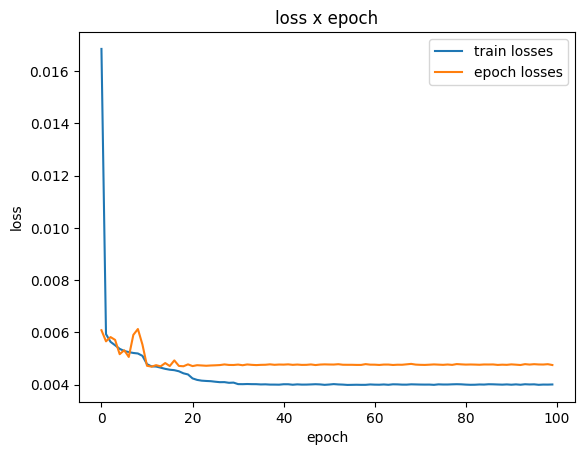

In [10]:
plt.plot(train_epoch_losses, label='train losses')
plt.plot(val_epoch_losses, label='epoch losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss x epoch')
plt.legend()